# Traffic Light Classifier
**In this notebook, a deep learning approach is used for the purposes of detecting traffic lights and their corresponding state representation (i.e. Red, Green, Yellow).**

In [1]:
# Dependencies
# Load pickled data
import pickle
import os
import numpy as np
import glob
import matplotlib.pyplot as plt

from math import *

%matplotlib inline
plt.style.use('ggplot')

*Define the training and test paths...*

In [2]:
import model.modelconfig as config

# Define training data paths
training_path = "./data/train/images"
test_path = "./data/test/images"

model_path = "./model/deepnet-noiseless/"

if not os.path.exists(model_path):
    os.mkdir(model_path)

In [3]:
# Extract number of samples

def get_samples(path, patterns = ("*.png", "*.jpg")):
    paths = []
    for key in list(config.labels.keys()):
        dir = os.path.join(path, key)
        for pattern in patterns:
            paths += glob.glob(os.path.join(dir, pattern))
    return paths

train_samples = get_samples(training_path)
test_samples = get_samples(test_path)

print("Number of training samples: {}".format(len(train_samples)))
print("Number of test samples: {}".format(len(test_samples)))

Number of training samples: 38868
Number of test samples: 23135


In [4]:
# Uncomment to disable GPU acceleration
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [5]:
import keras;
import tensorflow as tf
import keras.backend as K

# Check keras and tensorflow versions
print("Keras version: {}".format(keras.__version__))
print("TensorFlow version: {}".format(tf.__version__))
print("Channels: {}".format(K.image_data_format()))

# Check for a GPU
if not tf.test.gpu_device_name():
    print('No GPU found. Using CPU...')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

Using TensorFlow backend.


Keras version: 2.0.8
TensorFlow version: 1.0.0
Channels: channels_last
Default GPU Device: /gpu:0


### SqueezeNet model

In [3]:
class_labels = list(set(config.labels.values()))
print("Class labels: \n{}".format(class_labels))

Class labels: 
[0, 1, 2, 12]


In [7]:
# Model params
output_size = len(class_labels)
image_size = (None, None, 3)

dropout = 0.0
weight_decay = 1e-4

# Build model
from model.DeepNet import DeepNet

model = DeepNet(output_size, image_size, dropout, weight_decay)

C:\Users\chris\Source\perception\model\DeepNet.py:61: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, kernel_regularizer=<keras.reg..., bias_regularizer=<keras.reg...)`
  output = Dense(256, W_regularizer=regularizers.l2(weight_decay), b_regularizer=regularizers.l2(weight_decay))(output)


#### Define Optimiser for Training

In [8]:
# Optimiser params
optimiser = "Adam"
loss = "categorical_crossentropy"
metrics = ["categorical_accuracy", "top_k_categorical_accuracy"]

# Compile model
model.compile(optimiser, loss, metrics=metrics, loss_weights=None, sample_weight_mode=None)

print("\n## Model ##")
print(model.summary())


## Model ##
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
normalizer_1 (Normalizer)    (None, None, None, 3)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    4864      
_________________________________________________________________
average_pooling2d_1 (Average (None, None, None, 64)    0         
_________________________________________________________________
activation_1 (Activation)    (None, None, None, 64)    0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 32)    18464     
_________________________________________________________________
average_pooling2d_2 (Average (None, None, None, 32)    0       

In [9]:
# Train on Bosch dataset
### Training parameters ###
noise = 0.0
batch_size = 32
max_epochs = 40

epoch_train_samples = int(floor(len(train_samples) / batch_size))
epoch_test_samples = int(floor(len(test_samples) / batch_size))

print("Steps per epoch (train): {}".format(epoch_train_samples))
print("Steps per epoch (test): {}".format(epoch_test_samples))

Steps per epoch (train): 1214
Steps per epoch (test): 722


### Training

*Define image data generators and create noise on training set.*

In [10]:
import data.helpers.generator as g

print("\nInitializing generators...")

# compile and train the model using the generator function
train_generator = g.generator(training_path, config.labels, batch_size = batch_size, noise = noise)
validation_generator = g.generator(test_path, config.labels, batch_size = batch_size, noise = 0)

print(" - Done.\n")


Initializing generators...
 - Done.



*Define callbacks for use during training.*

In [11]:
### Train ###
from keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint

# setup callbacks, save every checkpoint, check for overfitting and reduce learning rate as required
callbacks = [
    CSVLogger(model_path + "/training-loss.csv", separator=',', append = True),
    #EarlyStopping(monitor='val_loss', min_delta = 0.0001, patience = 7),
    ModelCheckpoint(filepath = model_path + config.checkpoint_pattern.replace("*","{epoch:02d}-{val_loss:.2f}"), monitor='val_loss', save_best_only=False, save_weights_only=True, verbose=0),
]

#### Learning

In [12]:
print("\nTraining...")

epoch = 0
# Train the model using the supplied generator
history = model.fit_generator(train_generator, steps_per_epoch = epoch_train_samples, 
                              validation_data = validation_generator, validation_steps = epoch_test_samples,
                              epochs = max_epochs, callbacks = callbacks, initial_epoch = epoch)


Training...
Epoch 1/40
1214/1214 [==============================] - 235s - loss: 0.7415 - categorical_accuracy: 0.7032 - top_k_categorical_accuracy: 1.0000 - val_loss: 1.1061 - val_categorical_accuracy: 0.6767 - val_top_k_categorical_accuracy: 1.0000
Epoch 2/40
1214/1214 [==============================] - 156s - loss: 0.3229 - categorical_accuracy: 0.8976 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.8894 - val_categorical_accuracy: 0.7390 - val_top_k_categorical_accuracy: 1.0000
Epoch 3/40
1214/1214 [==============================] - 146s - loss: 0.2395 - categorical_accuracy: 0.9313 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.8623 - val_categorical_accuracy: 0.7760 - val_top_k_categorical_accuracy: 1.0000
Epoch 4/40
1214/1214 [==============================] - 139s - loss: 0.2096 - categorical_accuracy: 0.9428 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.8176 - val_categorical_accuracy: 0.7672 - val_top_k_categorical_accuracy: 1.0000
Epoch 5/40
1214/1214 [=========

In [13]:
print(history.history.keys())

dict_keys(['val_loss', 'loss', 'val_top_k_categorical_accuracy', 'val_categorical_accuracy', 'categorical_accuracy', 'top_k_categorical_accuracy'])


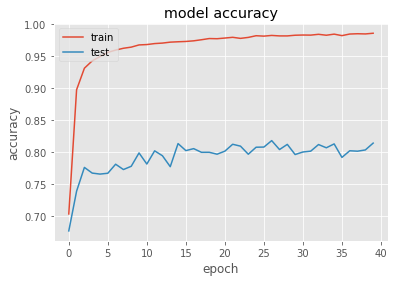

In [14]:
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')


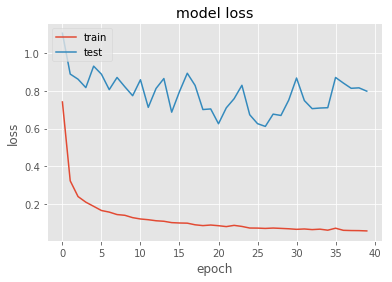

In [15]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [4]:
valid_path = "./data/valid/images"

In [7]:
model.load_weights(model_path + "checkpoint-26-0.61.h5")

Using TensorFlow backend.
C:\Users\palladium\Source\Repos\CarND-Capstone-Project\perception_170506\model\DeepNet.py:61: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, kernel_regularizer=<keras.reg..., bias_regularizer=<keras.reg...)`
  output = Dense(256, W_regularizer=regularizers.l2(weight_decay), b_regularizer=regularizers.l2(weight_decay))(output)


InvalidArgumentError: computed output size would be negative
	 [[Node: average_pooling2d_3/AvgPool = AvgPool[T=DT_FLOAT, data_format="NHWC", ksize=[1, 2, 2, 1], padding="VALID", strides=[1, 1, 1, 1], _device="/job:localhost/replica:0/task:0/cpu:0"](conv2d_3/BiasAdd)]]

Caused by op 'average_pooling2d_3/AvgPool', defined at:
  File "C:\Users\palladium\AppData\Local\Continuum\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\palladium\AppData\Local\Continuum\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\palladium\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "C:\Users\palladium\AppData\Local\Continuum\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\palladium\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "C:\Users\palladium\AppData\Local\Continuum\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\palladium\AppData\Local\Continuum\Anaconda3\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\Users\palladium\AppData\Local\Continuum\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\palladium\AppData\Local\Continuum\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\palladium\AppData\Local\Continuum\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\palladium\AppData\Local\Continuum\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\palladium\AppData\Local\Continuum\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\palladium\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\palladium\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\palladium\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\palladium\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\palladium\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\palladium\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\palladium\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\palladium\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-a0af72fe509c>", line 11, in <module>
    model = DeepNet(output_size, image_size, dropout, weight_decay)
  File "C:\Users\palladium\Source\Repos\CarND-Capstone-Project\perception_170506\model\DeepNet.py", line 47, in DeepNet
    output = AveragePooling2D((2, 2), strides=(1, 1))(output)
  File "C:\Users\palladium\AppData\Local\Continuum\Anaconda3\lib\site-packages\keras\engine\topology.py", line 602, in __call__
    output = self.call(inputs, **kwargs)
  File "C:\Users\palladium\AppData\Local\Continuum\Anaconda3\lib\site-packages\keras\layers\pooling.py", line 154, in call
    data_format=self.data_format)
  File "C:\Users\palladium\AppData\Local\Continuum\Anaconda3\lib\site-packages\keras\layers\pooling.py", line 271, in _pooling_function
    padding, data_format, pool_mode='avg')
  File "C:\Users\palladium\AppData\Local\Continuum\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py", line 3388, in pool2d
    x = tf.nn.avg_pool(x, pool_size, strides, padding=padding)
  File "C:\Users\palladium\AppData\Local\Continuum\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 1765, in avg_pool
    name=name)
  File "C:\Users\palladium\AppData\Local\Continuum\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 50, in _avg_pool
    data_format=data_format, name=name)
  File "C:\Users\palladium\AppData\Local\Continuum\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "C:\Users\palladium\AppData\Local\Continuum\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 2395, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\Users\palladium\AppData\Local\Continuum\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1264, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): computed output size would be negative
	 [[Node: average_pooling2d_3/AvgPool = AvgPool[T=DT_FLOAT, data_format="NHWC", ksize=[1, 2, 2, 1], padding="VALID", strides=[1, 1, 1, 1], _device="/job:localhost/replica:0/task:0/cpu:0"](conv2d_3/BiasAdd)]]


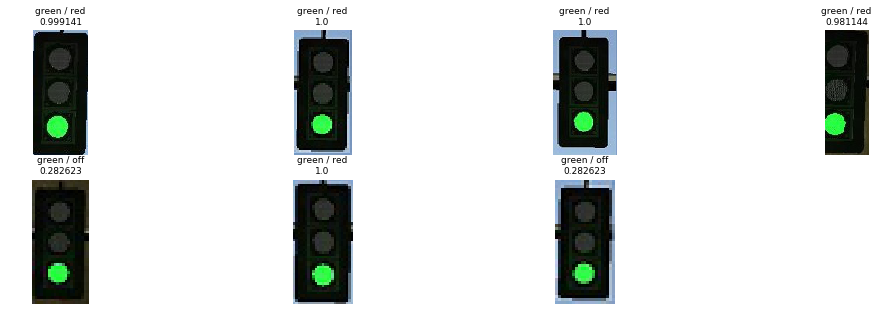

In [8]:
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg

images = []
labels = []
labelnames = []

for dir in os.listdir(valid_path):
    sub_path = os.path.join(valid_path, dir)
    if (os.path.isdir(sub_path) and dir in config.labels):
        for img_name in os.listdir(sub_path):
            img_path = os.path.join(sub_path, img_name)
            images.append(img_path)
            labels.append(config.labels[dir])
            labelnames.append(dir)

num_rows = 6
num_cols = 4

fig = plt.figure(figsize=(18, 16))  # width, height in inches

k = 1

for i in range(len(labels)):
    image = mpimg.imread(images[i])
    label = labels[i]
    name = labelnames[i]
    
    image = np.asarray(image)
    
    pred = model.predict(image[None, :, :, 0:3], batch_size=1)[0]
    
    pred_idx = np.argmax(pred)
    pred_label = list(config.labels)[pred_idx]
    pred_score = np.round(pred[pred_idx], 6)
    
    sub = fig.add_subplot(num_rows, num_cols, k)
    sub.set_title("{} / {}\n{}".format(name, pred_label, str(pred_score)), fontsize=9)
    sub.imshow(image)
    #sub.axis("off")
    
    color = "red"
    if (pred_label == label):
        color = "lime"
            
    #sub.set_label(str(pred_score))#, fontsize=8, color=color)
    sub.axis('off')
    
    k += 1

fig.suptitle("Traffic Lights",fontsize=12)


In [ ]:
# Write out model params to file for use in project